In [27]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import scatter_matrix

from itertools import chain

##### The following is cleaning and preparing data. There is no need to run it again.

In [34]:
# Load and clean data from Steam Charts data file, scrapped by Alex. Do not run this again.
data = pd.read_csv('../Alex/Data_Scraping/GamesData.csv',index_col=False)

# Clean data
data = data.iloc[2:].reset_index(drop=True)#.drop(columns='Unnamed: 0')

# Make percentile into number and clear "-"
data = data.replace(to_replace='%', value='', regex=True).replace({'-':'NaN'})
data = data[2:].reset_index(drop=True).drop(columns='Unnamed: 0')

data = data.rename(columns=lambda x: x.replace('_', ' '))
data = data.rename(columns={'App id':'App_id','Avg Players':'Avg_Players', 'Peak Players':'Peak_Players','Perc Gain': 'Perc_Gain'}, errors="raise")

# Save the cleaned data as 'SteamCharts.csv'
data.to_csv('SteamCharts.csv',index=False)

In [29]:
# Load data from 'SteamCharts.csv' data file
data = pd.read_csv('SteamCharts.csv',index_col=False,low_memory=False)

# Get Perc_Gain.
p_gain = data.loc[data['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
p_gain_pure = p_gain.drop(columns=['App_id', 'Name']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_players = avg_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)

# Get Peak_Players.
peak_players = data.loc[data['Peak_Players']==1]
peak_players = peak_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
peak_pure = peak_players.drop(columns=['App_id', 'Name']).astype(float)

# Add columns of max and mean
avg_players['max'] = avg_pure.max(axis=1)
avg_players['mean'] = avg_pure.mean(axis=1)

peak_players['peak_max'] = peak_pure.max(axis=1)
peak_players['peak_mean'] = peak_pure.mean(axis=1)

In [33]:
# Load data from Steam Spy data files. Do not run this, or download 'steamspy_owners.csv' and 'games-features-metacritic-new.csv' before you run:
steamspy = pd.read_csv('steamspy_owners.csv')
steamspy = steamspy.rename(columns={'QueryID':'App_id','0':'SteamSpyOwnersNew'}, errors="raise")

features = pd.read_csv('games-features-metacritic-new.csv',index_col=False)
features = features.drop_duplicates(subset=['QueryID','QueryName'], keep='first', inplace=False, ignore_index=False)
features = features.drop(columns=['ResponseID', 'ResponseName'])
features = features.rename(columns={'QueryID':'App_id','QueryName':'Name'}, errors="raise")

# Combine data from Steam Charts and Steam Spy, order it by 'max' and save it as 'AllData.csv'
data_all = pd.merge(features, steamspy[['App_id','SteamSpyOwnersNew']], how='inner', on=['App_id'])
data_all = pd.merge(data_all, peak_players[['App_id','peak_max','peak_mean']], how='inner', on=['App_id'])
data_all = pd.merge(data_all, avg_players[['App_id','max','mean']], how='inner', on=['App_id'])
data_all.sort_values(by=['max'], ascending=False, inplace=True)

data_all.reset_index(drop=True).drop(columns='Unnamed: 0').drop_duplicates(subset=['Name'], keep='first', inplace=False, ignore_index=False).to_csv('AllData.csv',index=False)

## Start your data anlaysis here:

Explanation of the csv files:

The file `SteamCharts.csv` contains monthly data of 'Avg_Players', 'Gain', 'Perc_Gain' and 'Peak_Players' (obtained from [Steam Charts](https://steamcharts.com/) by Alex).

The file `AllData.csv` contains 70+ game features (obtained from [Steam Spy](https://steamspy.com/) by Kanishk), together with the max and mean of 'Avg_Players' and the max and mean of 'Peak_Players'. This file is a combination of Steam Spy data and Steam Charts data through the common 'App_id's. It is currently sorted by the max of 'Avg_Players'.


In [40]:
data_charts = pd.read_csv('SteamCharts.csv',index_col=False,low_memory=False)

# Get Perc_Gain.
p_gain = data_charts.loc[data_charts['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
p_gain_pure = p_gain.drop(columns=['App_id', 'Name']).astype(float)

# Get Avg_Players.
avg_players = data_charts.loc[data_charts['Avg_Players']==1]
avg_players = avg_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)

# Get Peak_Players.
peak_players = data_charts.loc[data_charts['Peak_Players']==1]
peak_players = peak_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
peak_pure = peak_players.drop(columns=['App_id', 'Name']).astype(float)

In [61]:
data = pd.read_csv('AllData.csv')
print('There are '+str(len(data))+' games.')

There are 10576 games.


In [62]:
data = pd.read_csv('AllData.csv')

cutoff = 10
data = data.loc[data['mean']>10]

print('There are '+str(len(data))+' games whose average number of players per month is larger than '+str(cutoff)+'.')

There are 5090 games whose average number of players per month is larger than 10.


In [63]:
data = pd.read_csv('AllData.csv')
data = data.loc[data['Metacritic']>-1]

print('There are '+str(len(data))+' games with a metacritic score.')

There are 2194 games with a metacritic score.


In [64]:
data = pd.read_csv('AllData.csv')

data = data.loc[data['mean']>10]
data = data.loc[data['Metacritic']>-1]

print('There are '+str(len(data))+' games with metacritic score and whose average number of players per month is larger than '+str(cutoff)+'.')

There are 1647 games with metacritic score and whose average number of players per month is larger than 10.


In [46]:
data.columns

Index(['App_id', 'Name', 'ReleaseDate', 'RequiredAge', 'DemoCount',
       'DeveloperCount', 'DLCCount', 'Metacritic', 'MovieCount',
       'PackageCount', 'RecommendationCount', 'PublisherCount',
       'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
       'AchievementCount', 'AchievementHighlightedCount', 'ControllerSupport',
       'IsFree', 'FreeVerAvail', 'PurchaseAvail', 'SubscriptionAvail',
       'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin',
       'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec',
       'MacReqsHaveMin', 'MacReqsHaveRec', 'CategorySinglePlayer',
       'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'GenreIsNonGame',
       'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
       'GenreIsStrategy', 'GenreIsRPG', 'Genr

In [47]:
data['GenreIsGame'] = 1 -data['GenreIsNonGame']
data['GenreIsGame'] = data['GenreIsGame'].astype('bool')

genre = [#'GenreIsGame',
       'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
       'GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation',
       'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'GenreIsSports',
       'GenreIsRacing', 'GenreIsMassivelyMultiplayer']

genre_name = [#'IsGame',
       'Indie', 'Action', 'Adventure', 'Casual',
       'Strategy', 'RPG', 'Simulation',
       'EarlyAccess', 'FreeToPlay', 'Sports',
       'Racing', 'MassivelyMultiplayer']

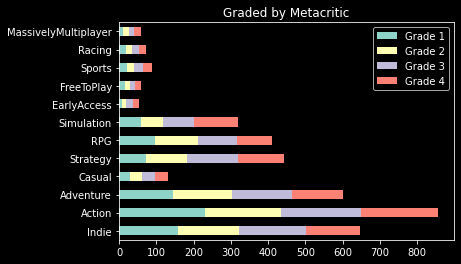

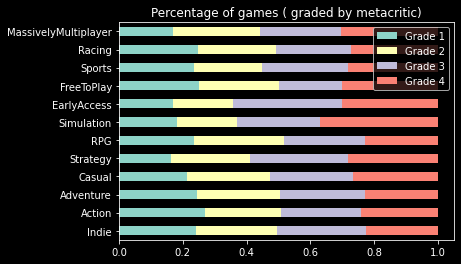

In [65]:
method = 'Metacritic'
#print('Graded by ' +str(method))

data.sort_values(by=[method ], ascending=False, inplace=True)#.reset_index(drop=True)

ranks = [0,412,824,1236]
#ranks = [0,550,1100,1650]
#ranks = [0,1274,2548,3822]
grade = list(range(1,len(ranks)+1))
a = np.array(ranks[1:]+[len(data)] ) - np.array([0] + ranks[1:])
grades = []
for i in range(len(grade)):
    grades.append( [grade[i]]*a[i] )    
grades = list(chain(*grades))

data['grade'] = grades

#for i in range(len(genre)):
    #sub_data = data.loc[data[genre[i]]==True]
    #print('There are '+str(len(sub_data))+' '+ str(genre_name[i]))
    #sub_data.grade.value_counts().plot(kind='barh')#,figsize=(7, 6), rot=0)

b=[]
b_perc=[]
for j in range(len(genre)):
    sub_data = data.loc[data[genre[j]]==True]
    b.append( [len(sub_data.loc[sub_data['grade']==i]) for i in range(1,len(grade)+1)])
    b_perc.append(np.array(b[j])/len(sub_data) )

new_df = pd.DataFrame(b, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)
perc_df = pd.DataFrame(b_perc, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)

plt.style.use('dark_background')

ax = new_df.plot.barh(stacked=True,title='Graded by ' +str(method))
fig = ax.get_figure()
fig.savefig('figure1.png',bbox_inches="tight")

ax = perc_df.plot.barh(stacked=True,title='Percentage of games ('+' graded by metacritic)')
fig = ax.get_figure()
fig.savefig('figure2.png',bbox_inches="tight")

Graded by mean


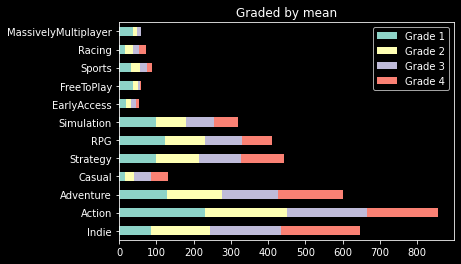

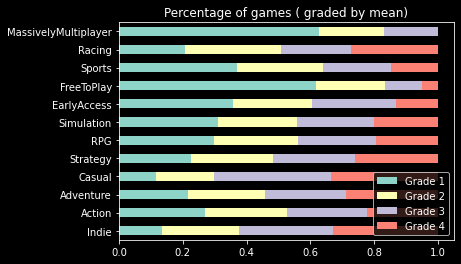

In [66]:
method = 'mean'
print('Graded by ' +str(method))

data.sort_values(by=[method ], ascending=False, inplace=True)#.reset_index(drop=True)

ranks = [0,412,824,1236]
#ranks = [0,550,1100,1650]
#ranks = [0,1274,2548,3822]
grade = list(range(1,len(ranks)+1))
a = np.array(ranks[1:]+[len(data)] ) - np.array( [0] + ranks[1:])
grades = []
for i in range(len(grade)):
    grades.append( [grade[i]]*a[i] )    
grades = list(chain(*grades))

data['grade'] = grades

#for i in range(len(genre)):
    #sub_data = data.loc[data[genre[i]]==True]
    #print('There are '+str(len(sub_data))+' '+ str(genre_name[i]))
    #sub_data.grade.value_counts().plot(kind='barh')#,figsize=(7, 6), rot=0)

b=[]
b_perc=[]
for j in range(len(genre)):
    sub_data = data.loc[data[genre[j]]==True]
    b.append( [len(sub_data.loc[sub_data['grade']==i]) for i in range(1,len(grade)+1)])
    b_perc.append(np.array(b[j])/len(sub_data) )

new_df = pd.DataFrame(b, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)
perc_df = pd.DataFrame(b_perc, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)

plt.style.use('dark_background')

ax = new_df.plot.barh(stacked=True,title='Graded by ' +str(method))
fig = ax.get_figure()
fig.savefig('figure11.png',bbox_inches="tight")

ax = perc_df.plot.barh(stacked=True,title='Percentage of games ('+' graded by ' +str(method)+ ')')
fig = ax.get_figure()
fig.savefig('figure21.png',bbox_inches="tight")

Graded bymax


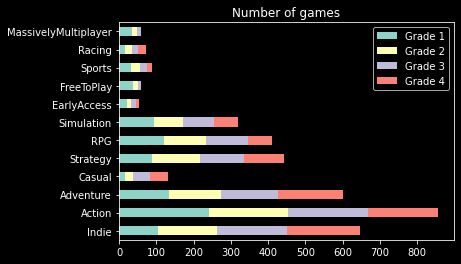

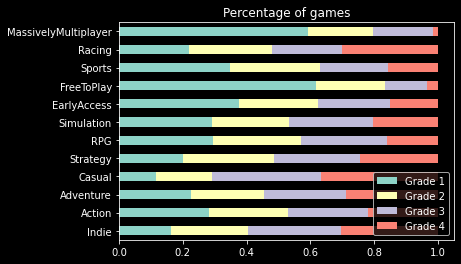

In [67]:
method = 'max'
print('Graded by' +str(method))

data.sort_values(by=[method ], ascending=False, inplace=True)#.reset_index(drop=True)

ranks = [0,412,824,1236]
#ranks = [0,550,1100,1650]
#ranks = [0,1274,2548,3822]
grade = list(range(1,len(ranks)+1))
a = np.array(ranks[1:]+[len(data)] ) - np.array( [0] + ranks[1:])
grades = []
for i in range(len(grade)):
    grades.append( [grade[i]]*a[i] )    
grades = list(chain(*grades))

data['grade'] = grades

#for i in range(len(genre)):
    #sub_data = data.loc[data[genre[i]]==True]
    #print('There are '+str(len(sub_data))+' '+ str(genre_name[i]))
    #sub_data.grade.value_counts().plot(kind='barh')#,figsize=(7, 6), rot=0)

b=[]
b_perc=[]
for j in range(len(genre)):
    sub_data = data.loc[data[genre[j]]==True]
    b.append( [len(sub_data.loc[sub_data['grade']==i]) for i in range(1,len(grade)+1)])
    b_perc.append(np.array(b[j])/len(sub_data) )

new_df = pd.DataFrame(b, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)
perc_df = pd.DataFrame(b_perc, columns=["Grade 1", "Grade 2", "Grade 3", "Grade 4"], index =genre_name)

plt.style.use('dark_background')

ax = new_df.plot.barh(stacked=True,title='Number of games')
fig = ax.get_figure()
fig.savefig('figure11.png',bbox_inches="tight")

ax = perc_df.plot.barh(stacked=True,title='Percentage of games')
fig = ax.get_figure()
fig.savefig('figure21.png',bbox_inches="tight")

In [68]:
data = pd.read_csv('AllData.csv')
data = data.sort_values(by = 'App_id')

avg_players = avg_players.sort_values(by='App_id').reset_index(drop=True)

avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)
for i in range(10):
    avg_pure.iloc[i]= avg_pure.iloc[i]/ (avg_pure.iloc[i].mean())
#avg_pure.iloc[1]= avg_pure.iloc[1]/ (avg_pure.iloc[1].mean())

avg_players

,Name,App_id,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,Counter-Strike,10,12426.28,12311.34,12091.33,13094.31,12239.53,11278.70,10320.58,9983.94,...,21204.46,24139.15,28378.42,34814.47,31996.07,29669.97,28836.29,29432.56,33095.8,34139.20
1,Team Fortress Classic,20,57.63,61.19,68.31,79.08,74.00,70.45,69.89,70.08,...,73.58,77.73,82.32,89.0,87.79,78.58,77.51,83.83,93.03,98.17
2,Day of Defeat,30,103.37,105.42,112.93,117.04,112.77,109.85,104.98,101.19,...,217.9,297.55,318.41,319.62,318.08,303.99,297.0,289.59,304.47,331.84
3,Deathmatch Classic,40,2.95,4.42,4.90,4.41,4.78,6.74,7.45,7.28,...,4.64,5.78,7.11,6.91,6.72,6.18,5.56,6.26,7.41,8.61
4,Half-Life: Opposing Force,50,83.77,89.22,105.72,128.28,111.27,93.25,78.46,80.01,...,43.04,39.92,43.15,50.2,47.06,38.63,41.3,56.26,55.77,79.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12520,Increlution Demo,1628530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12521,Pocket Bravery Demo,1630860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12522,Severed Steel Demo,1631910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12523,Play With Gilbert - Unicorn Supporter Pack,1634400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


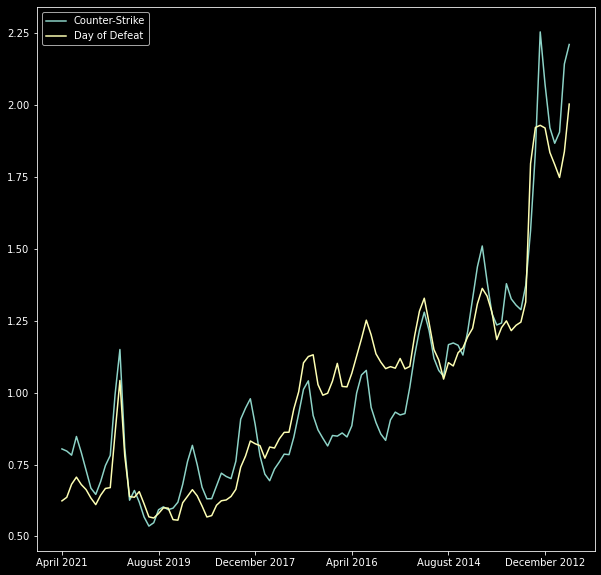

In [70]:
avg_pure.iloc[0].plot(figsize=(12,12),label = avg_players.Name[0])
avg_pure.iloc[2].plot(figsize=(10,10),label = avg_players.Name[2])
plt.legend()

In [71]:
#standard: a column name used to rank the games
#ranks: a list of rank cutoffs

def grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=(12,12)):
       
    grade = list(range(1,len(ranks)+1))
    a = np.array(ranks[1:]+[len(data)] ) - np.array( [0] + ranks[1:])
    grades = []
    for i in range(len(grade)):
        grades.append( [grade[i]]*a[i] )    
    grades = list(chain(*grades))
    
    # Sort data according to the 'standard'
    data_copy=data.copy()
    data_copy.sort_values(by=[standard], ascending=False, inplace=True)#.reset_index(drop=True)
    avg_graded = data_copy#.loc[data[standard]>=1].copy()

    # Rank the games
    if plot_cutoff:
        print('Using '+str(standard)+' :')
        for i in ranks:
            print('The cutoff for top '+str(i)+' games is '+str(avg_graded.reset_index(drop=True)[standard][i]))

    cutoffs = [0] + [avg_graded.reset_index(drop=True)[standard][i] for i in ranks[::-1]]
    #counts  = avg_graded[standard].value_counts(bins=cutoffs, sort=False,dropna=False) 
    #print(counts)

    #avg_graded = avg_players.loc[avg_players[standard]>=1].copy()
    avg_graded['Grade'] = grades

    data_clean = avg_graded[genre+['Grade']]

#threshold = .2
#data_clean = data_clean.drop(data_clean.mean(axis=0)[data_clean.mean(axis=0) < threshold].index.values,axis=1)

    data_clean.columns = genre_name+['Grade']

    data_test = {}
    for i in grade:
        data_test[i] = data_clean.loc[data_clean['Grade']==i].drop(columns=['Grade'])
        
    if plot_figures:
        plt.figure(figsize=fig_size)
        for i in grade:
            plt.plot(data_test[i].columns,data_test[i].mean(),label='Grade '+str(i))

        plt.legend()
        plt.title('By max of Avg_players')
        plt.show()
    return data_test

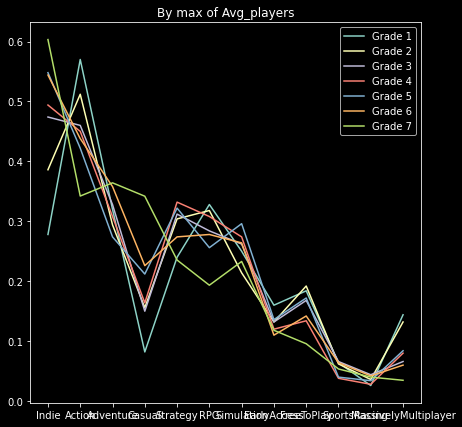

In [72]:
# We plot one figure given one ranking method here:
fig_size=(7,7)
ranks = list(np.arange(0,3500,500))
data_max = grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=fig_size)

In [73]:
# This function plots different methods together:
def grade_analysis_plot_all(methods,ranks,fig_size=(24,6)):
    fig,ax=plt.subplots(1,len(methods),figsize=fig_size)
    for j in range(len(methods)):
        data_copy = grade_analysis(ranks,standard= methods[j], plot_figures=False)
        for i in list(range(1,len(ranks)+1)):    
            ax[j].plot(data_copy[i].columns,data_copy[i].mean(),label='Grade '+str(i))
            ax[j].set_title('By '+str(methods[j]))
        ax[j].legend()
    plt.show()

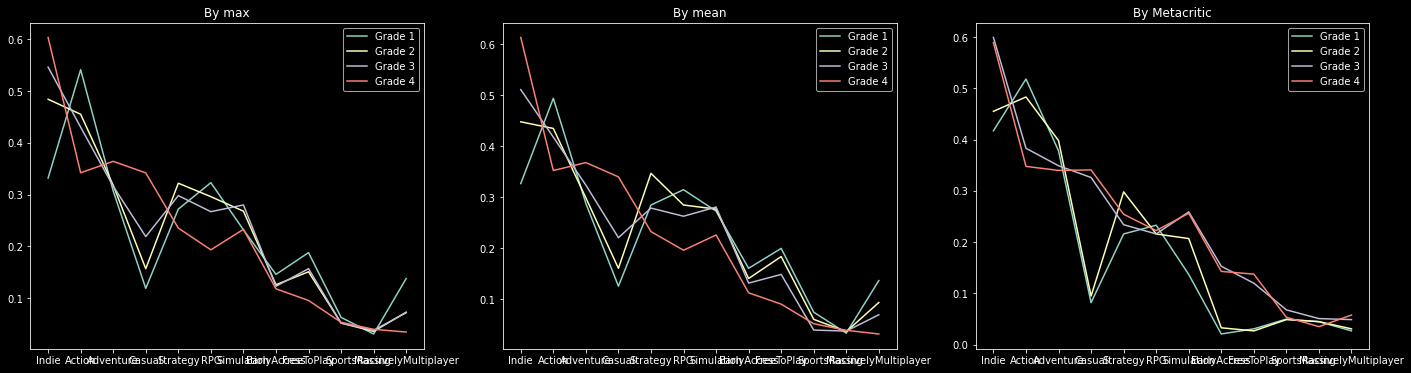

Rank cutoffs are [0, 1000, 2000, 3000]


In [74]:
methods = ['max','mean','Metacritic']
ranks = list(np.arange(0,3500,1000))
grade_analysis_plot_all(methods,ranks,fig_size=(24,6))
print('Rank cutoffs are '+str(ranks))

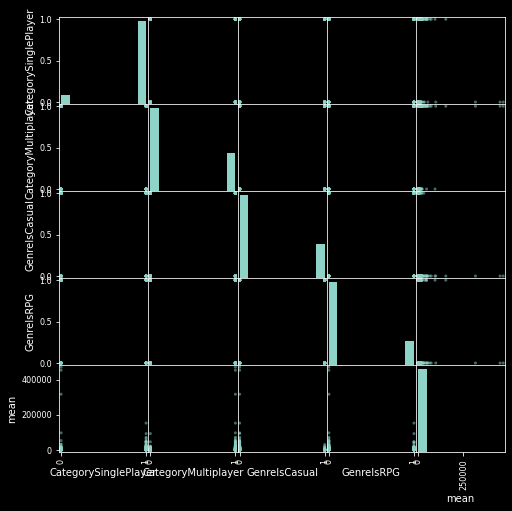

In [75]:
data_test = data[[ #'RecommendationCount',
        'CategorySinglePlayer',
       'CategoryMultiplayer', 
#       'GenreIsIndie', 
#                       'GenreIsAction', 
#                        'GenreIsAdventure', 
                        'GenreIsCasual',
#       'GenreIsStrategy', 
                         'GenreIsRPG', 
#                        'GenreIsSimulation', 
       #'PriceFinal',
                        'mean']].astype(float)

scatter_matrix(data_test,figsize=(8,8))
plt.show()

In [ ]:
data.mean()